# Insurance Claim Approval ML

This notebook walks through:
- Loading and exploring the dataset
- Preprocessing and encoding features
- Training a classification model
- Flagging claims for manual review based on model uncertainty

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


In [3]:
# Load dataset
df = pd.read_csv('../data/enhanced_health_insurance_claims.csv')
df.head()

,ClaimID,PatientID,ProviderID,ClaimAmount,ClaimDate,DiagnosisCode,ProcedureCode,PatientAge,PatientGender,ProviderSpecialty,ClaimStatus,PatientIncome,PatientMaritalStatus,PatientEmploymentStatus,ProviderLocation,ClaimType,ClaimSubmissionMethod
0,10944daf-f7d5-4e1d-8216-72ffa609fe41,8552381d-7960-4f64-b190-b20b8ada00a1,4a4cb19c-4863-41cf-84b0-c2b21aace988,3807.95,2024-06-07,yy006,hd662,16,M,Cardiology,Pending,90279.43,Married,Retired,Jameshaven,Routine,Paper
1,fcbebb25-fc24-4c0f-a966-749edcf83fb1,327f43ad-e3bd-4473-a9ed-46483a0a156f,422e02dd-c1fd-43dd-8af4-0c3523f997b1,9512.07,2023-05-30,tD052,mH831,27,M,Pediatrics,Approved,130448.02,Single,Student,Beltrantown,Routine,Online
2,9e9983e7-9ea7-45f5-84d8-ce49ccd8a4a1,6f3acdf7-73aa-4afa-9c2e-b25b27bdb5b0,f7733b3f-0980-47b5-a7a0-ee390869355b,7346.74,2022-09-27,zx832,dg637,40,F,Cardiology,Pending,82417.54,Divorced,Employed,West Charlesport,Emergency,Online
3,a06273ed-44bb-452b-bbad-8618de080494,5d58e183-701e-406c-a8c6-5b73cac5e912,f7a04581-de96-44ee-b773-8adac02baa59,6026.72,2023-06-25,kr421,kG326,65,M,Neurology,Pending,68516.96,Widowed,Student,West Aprilhaven,Routine,Phone
4,f702a717-254b-4cff-a0c7-8395db2f6616,8a8ebdf6-3af0-4f14-82f3-37b937c3d270,b80b9e77-97f0-47d7-b561-19f9658a7bdf,1644.58,2023-07-24,LZ261,cx805,24,M,General Practice,Pending,84122.17,Married,Student,Lake Michele,Inpatient,Phone


## Basic Cleaning + Target Setup

In [4]:
# Drop PENDING claims and convert target to binary

df = df[df['ClaimStatus'].isin(['Approved', 'Denied'])].copy()
df['Target'] = (df['ClaimStatus'] == 'Approved').astype(int)

# Drop identifiers and target
X = df.drop(columns=['ClaimID', 'PatientID', 'ProviderID', 'ClaimStatus', 'Target', 'ClaimDate'])
y = df['Target']

## Class Distribution


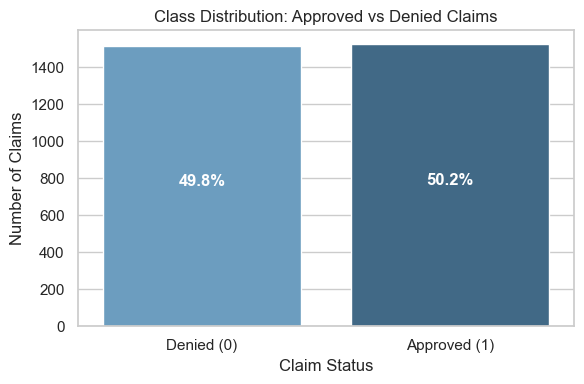

In [5]:
# Prepare data
class_counts = df['Target'].value_counts().sort_index()
class_labels = ['Denied (0)', 'Approved (1)']
percentages = class_counts / class_counts.sum() * 100

plot_df = pd.DataFrame({
    'Status': class_labels,
    'Count': class_counts.values,
    'Percent': percentages.values
})

# Plot
plt.figure(figsize=(6, 4))
sns.set_theme(style="whitegrid")
ax = sns.barplot(data=plot_df, x='Status', y='Count', hue='Status', palette='Blues_d', dodge=False)

# Improved label spacing
for i, v in enumerate(plot_df['Count']):
    plt.text(i, v * 0.5, f"{plot_df['Percent'][i]:.1f}%", ha='center', fontweight='bold', color='white')

plt.title('Class Distribution: Approved vs Denied Claims')
plt.ylabel('Number of Claims')
plt.xlabel('Claim Status')
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.show()


The dataset is nearly balanced, with 50.2% of claims approved and 49.8% denied.  
This balanced class distribution allows us to train classification models without the need for resampling techniques.


## Split and Preprocess

In [6]:
# Identify feature types
num_feats = ['ClaimAmount', 'PatientAge', 'PatientIncome']
cat_feats = [col for col in X.columns if col not in num_feats]

# Build preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_feats)
])

# Combine with model
pipeline = Pipeline([
    ('prep', preprocessor),
    ('clf', RandomForestClassifier(random_state=42))
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Fit model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['ClaimAmount', 'PatientAge',
                                                   'PatientIncome']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['DiagnosisCode',
                                                   'ProcedureCode',
                                                   'PatientGender',
                                                   'ProviderSpecialty',
                                                   'PatientMaritalStatus',
                                                   'PatientEmploymentStatus',
                                                   'ProviderLocation',
                                                   'ClaimType',
                                                   'ClaimSubmissionMethod'])])),
                ('clf', RandomForestClassifier(random_state=42))])

## Evaluate + Triage Logic

In [7]:
# Predict and get probabilities
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Evaluate
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Triage tagging
def triage_flag(prob):
    if 0.4 <= prob <= 0.6:
        return 'Needs Review'
    return 'Confident'

triage = pd.DataFrame({
    'Predicted': y_pred,
    'Prob_Approved': y_proba,
    'TriageFlag': [triage_flag(p) for p in y_proba]
})

triage['TriageFlag'].value_counts()

triage['TriageFlag'].value_counts(normalize=True) * 100


              precision    recall  f1-score   support

           0       0.51      0.47      0.49       302
           1       0.52      0.56      0.54       305

    accuracy                           0.52       607
   macro avg       0.52      0.52      0.51       607
weighted avg       0.52      0.52      0.51       607

ROC AUC: 0.51552491586147


TriageFlag
Needs Review    63.920923
Confident       36.079077
Name: proportion, dtype: float64

### Model Evaluation and Interpretation

The model’s current performance metrics indicate limited predictive power, with an overall ROC AUC close to 0.52 and balanced precision/recall near 0.5. This suggests the model is only slightly better than random guessing at this stage.

The triage logic flags about 64% of cases as 'Needs Review,' reflecting a cautious threshold to prioritize manual evaluation of uncertain predictions. Approximately 36% are classified with high confidence.

While these initial results highlight room for improvement, they demonstrate a valid workflow from data preprocessing through model training, prediction, and practical triage decision-making. Future work will focus on enhancing model accuracy and exploring interpretability techniques.


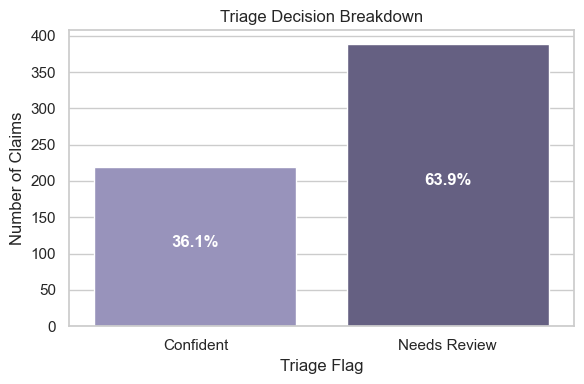

In [8]:
# Count triage flags
triage_counts = triage['TriageFlag'].value_counts().sort_index()
triage_labels = triage_counts.index.tolist()
triage_percent = triage_counts / triage_counts.sum() * 100

# Build DataFrame for plotting
triage_df = pd.DataFrame({
    'Flag': triage_labels,
    'Count': triage_counts.values,
    'Percent': triage_percent.values
})

# Adjusted y-offset for text labels
# Get y-axis upper limit and offset labels just above bars
plt.figure(figsize=(6, 4))
sns.set_theme(style="whitegrid")
ax = sns.barplot(data=triage_df, x='Flag', y='Count', hue='Flag', palette='Purples_d', dodge=False)

for i, v in enumerate(triage_df['Count']):
    plt.text(i, v * 0.5, f"{triage_df['Percent'][i]:.1f}%", ha='center', fontweight='bold', color='white')

plt.title('Triage Decision Breakdown')
plt.ylabel('Number of Claims')
plt.xlabel('Triage Flag')
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.show()



The triage logic flags 63.9% of claims for manual review based on prediction uncertainty (probability between 0.4 and 0.6), while 36.1% are classified with high confidence.  
This reflects a conservative model threshold to prioritize safety over automation.


## Random Forest Feature Importances
## Which Features Matter Most in Claim Approval?


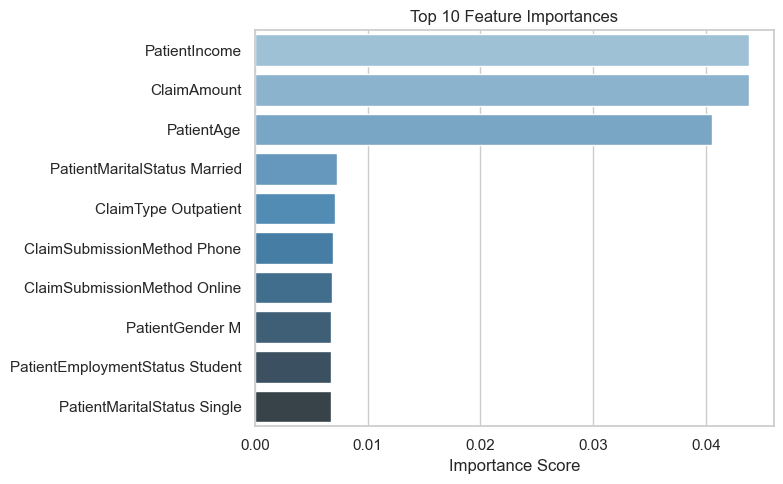

In [22]:
top_n = 10
importances = pipeline.named_steps['clf'].feature_importances_
feature_names = pipeline.named_steps['prep'].get_feature_names_out()

feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False).head(top_n)

feat_df['Feature'] = (
    feat_df['Feature']
    .str.replace('num__', '', regex=False)
    .str.replace('cat__', '', regex=False)
    .str.replace('_', ' ')
)

plt.figure(figsize=(8, 5))
sns.set_theme(style="whitegrid")

# Use the feature name as hue, and disable legend
ax = sns.barplot(
    data=feat_df,
    y='Feature',
    x='Importance',
    hue='Feature',        # triggers color assignment
    palette='Blues_d',
    dodge=False
)
plt.title(f'Top {top_n} Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('')
plt.legend([],[], frameon=False)  # remove legend
plt.tight_layout()
plt.show()



## Next Steps

- Optimize hyperparameters using grid search or random search to improve model accuracy  
- Evaluate alternative algorithms such as XGBoost, Logistic Regression, or Support Vector Machines  
- Use interpretability tools like SHAP or LIME to explain individual predictions and overall feature impact  
- Explore feature engineering techniques such as creating interaction terms or dimensionality reduction with PCA  
- Build an interactive dashboard using Streamlit or Dash to help users visualize and act on triage results  
- Perform rigorous validation with k-fold cross-validation and test on external datasets for generalizability  
- Assess ethical considerations, including fairness, bias, and patient privacy, before real-world deployment
